### A3: Geo-Python Jupyter Notebook

This script was originally inspired by https://github.com/marcusvolz/strava_py, with some modifications and refinements, from Strava data it is generating plot routes from .gpx files.

The main idea is that this dashboard will contain elevation models, routes, time-series diagrams, etc. This Python code only contains the generation of the routes, which it generates in an image, arranged side by side. The representation has a color scale that changes over time. Each part of the code has a short description.

I used Anaconda 24.11.3 to run it, which was installed with Python 3.12.3.

Links to the Python libraries used:
- pandas: https://pandas.pydata.org/docs/
- gpxpy: https://github.com/tkrajina/gpxpy
- fit2gpx: https://pypi.org/project/fit2gpx/
- matplotlib: https://matplotlib.org/
- seaborn: https://seaborn.pydata.org/

Some of these libraries are already installed with Anaconda, the remaining ones needs to be installed before running the first code. 

In [2]:
import os
import math
import pandas as pd
import gpxpy
import fit2gpx
import matplotlib.pyplot as plt
import seaborn as sns

Setting the folder to read out the .gpx files. (Path should be modified if you are using it with different data.)

In [3]:
folder = "./gpx"

Listing all the files in the previously set folder, it is only looking for files with .gpx or .fit ending, then constructing their full path using a join.

In [4]:
all_files = os.listdir(folder)
gpx_fit_files = [os.path.join(folder, f) for f in all_files if f.endswith((".gpx", ".fit"))]

Now, let's create an empty list for storing multiple pandas "dataframe" objects for later process in the code.

In [5]:
dfs = []

This code snippet processes .gpx and .fit files from the given folder and organizes the GPS data (longitude, latitude, altitude, time, filename, distance traveled) contained in them into a DataFrame.

In [6]:
for filepath in gpx_fit_files:
    print(f"Processing: {filepath}")
    
    if filepath.endswith(".gpx"):
        with open(filepath, encoding="utf-8") as f:
            try:
                activity = gpxpy.parse(f)
            except Exception as e:
                print(f"Error in the file ({filepath}): {e}")
                continue

        lon, lat, ele, time, name, dist = [], [], [], [], [], []

        for track in activity.tracks:
            for segment in track.segments:
                if not segment.points:
                    continue
                x0, y0, d0 = segment.points[0].longitude, segment.points[0].latitude, 0
                for point in segment.points:
                    x, y, z, t = point.longitude, point.latitude, point.elevation, point.time
                    d = d0 + math.sqrt((x - x0) ** 2 + (y - y0) ** 2)
                    lon.append(x)
                    lat.append(y)
                    ele.append(z)
                    time.append(t)
                    name.append(os.path.basename(filepath))
                    dist.append(d)
                    x0, y0, d0 = x, y, d

        df = pd.DataFrame({
            "lon": lon, "lat": lat, "ele": ele,
            "time": time, "name": name, "dist": dist
        })

    elif filepath.endswith(".fit"):
        try:
            conv = fit2gpx.Converter()
            df_lap, df = conv.fit_to_dataframes(fname=filepath)
        except Exception as e:
            print(f"Error in FIT file ({filepath}): {e}")
            continue

        df["name"] = os.path.basename(filepath)
        dist = []

        for i in range(len(df)):
            if i < 1:
                x0, y0, d0 = df["longitude"].iloc[0], df["latitude"].iloc[0], 0
            x, y = df["longitude"].iloc[i], df["latitude"].iloc[i]
            d = d0 + math.sqrt((x - x0) ** 2 + (y - y0) ** 2)
            dist.append(d)
            x0, y0, d0 = x, y, d

        df["dist"] = dist
        df = df.rename(columns={
            "longitude": "lon", "latitude": "lat",
            "altitude": "ele", "timestamp": "time"
        })
        df = df[["lon", "lat", "ele", "time", "name", "dist"]]

    else:
        continue

    dfs.append(df)


Processing: ./gpx\14196646513.gpx
Processing: ./gpx\14508069875.gpx
Processing: ./gpx\14705318029.gpx
Processing: ./gpx\14734920602.gpx
Processing: ./gpx\14734920621.gpx
Processing: ./gpx\14734920633.gpx
Processing: ./gpx\14734920639.gpx
Processing: ./gpx\14734920644.gpx
Processing: ./gpx\14734920650.gpx
Processing: ./gpx\14734920665.gpx
Processing: ./gpx\14734920670.gpx
Processing: ./gpx\14734920677.gpx
Processing: ./gpx\14736586592.gpx
Processing: ./gpx\14736586595.gpx
Processing: ./gpx\14736586614.gpx
Processing: ./gpx\14736586633.gpx
Processing: ./gpx\14736586653.gpx
Processing: ./gpx\14736586659.gpx
Processing: ./gpx\14736586665.gpx
Processing: ./gpx\14736586673.gpx
Processing: ./gpx\14736586681.gpx
Processing: ./gpx\14736586684.gpx
Processing: ./gpx\14736586690.gpx
Processing: ./gpx\14736586698.gpx
Processing: ./gpx\14736586726.gpx
Processing: ./gpx\14736599723.gpx
Processing: ./gpx\14736599750.gpx
Processing: ./gpx\14736599801.gpx
Processing: ./gpx\14736599835.gpx
Processing: ./

The next block ensures there is data, merges it, and prepares it for time-based analysis by extracting the date and hour from each GPS point’s timestamp.

In [7]:
if not dfs:
    print("No data to process")
    exit()

df_all = pd.concat(dfs, ignore_index=True)
df_all["time"] = pd.to_datetime(df_all["time"], utc=True)
df_all["date"] = df_all["time"].dt.date
df_all["hour"] = df_all["time"].dt.hour


This code creates a grid of scatterplots using Seaborn, where each subplot shows the GPS track (lon, lat) of a separate activity (from a .gpx or .fit file), colored by the hour of the day. The plots are arranged based on activity start times, and all axes and labels are hidden for a clean visual layout.

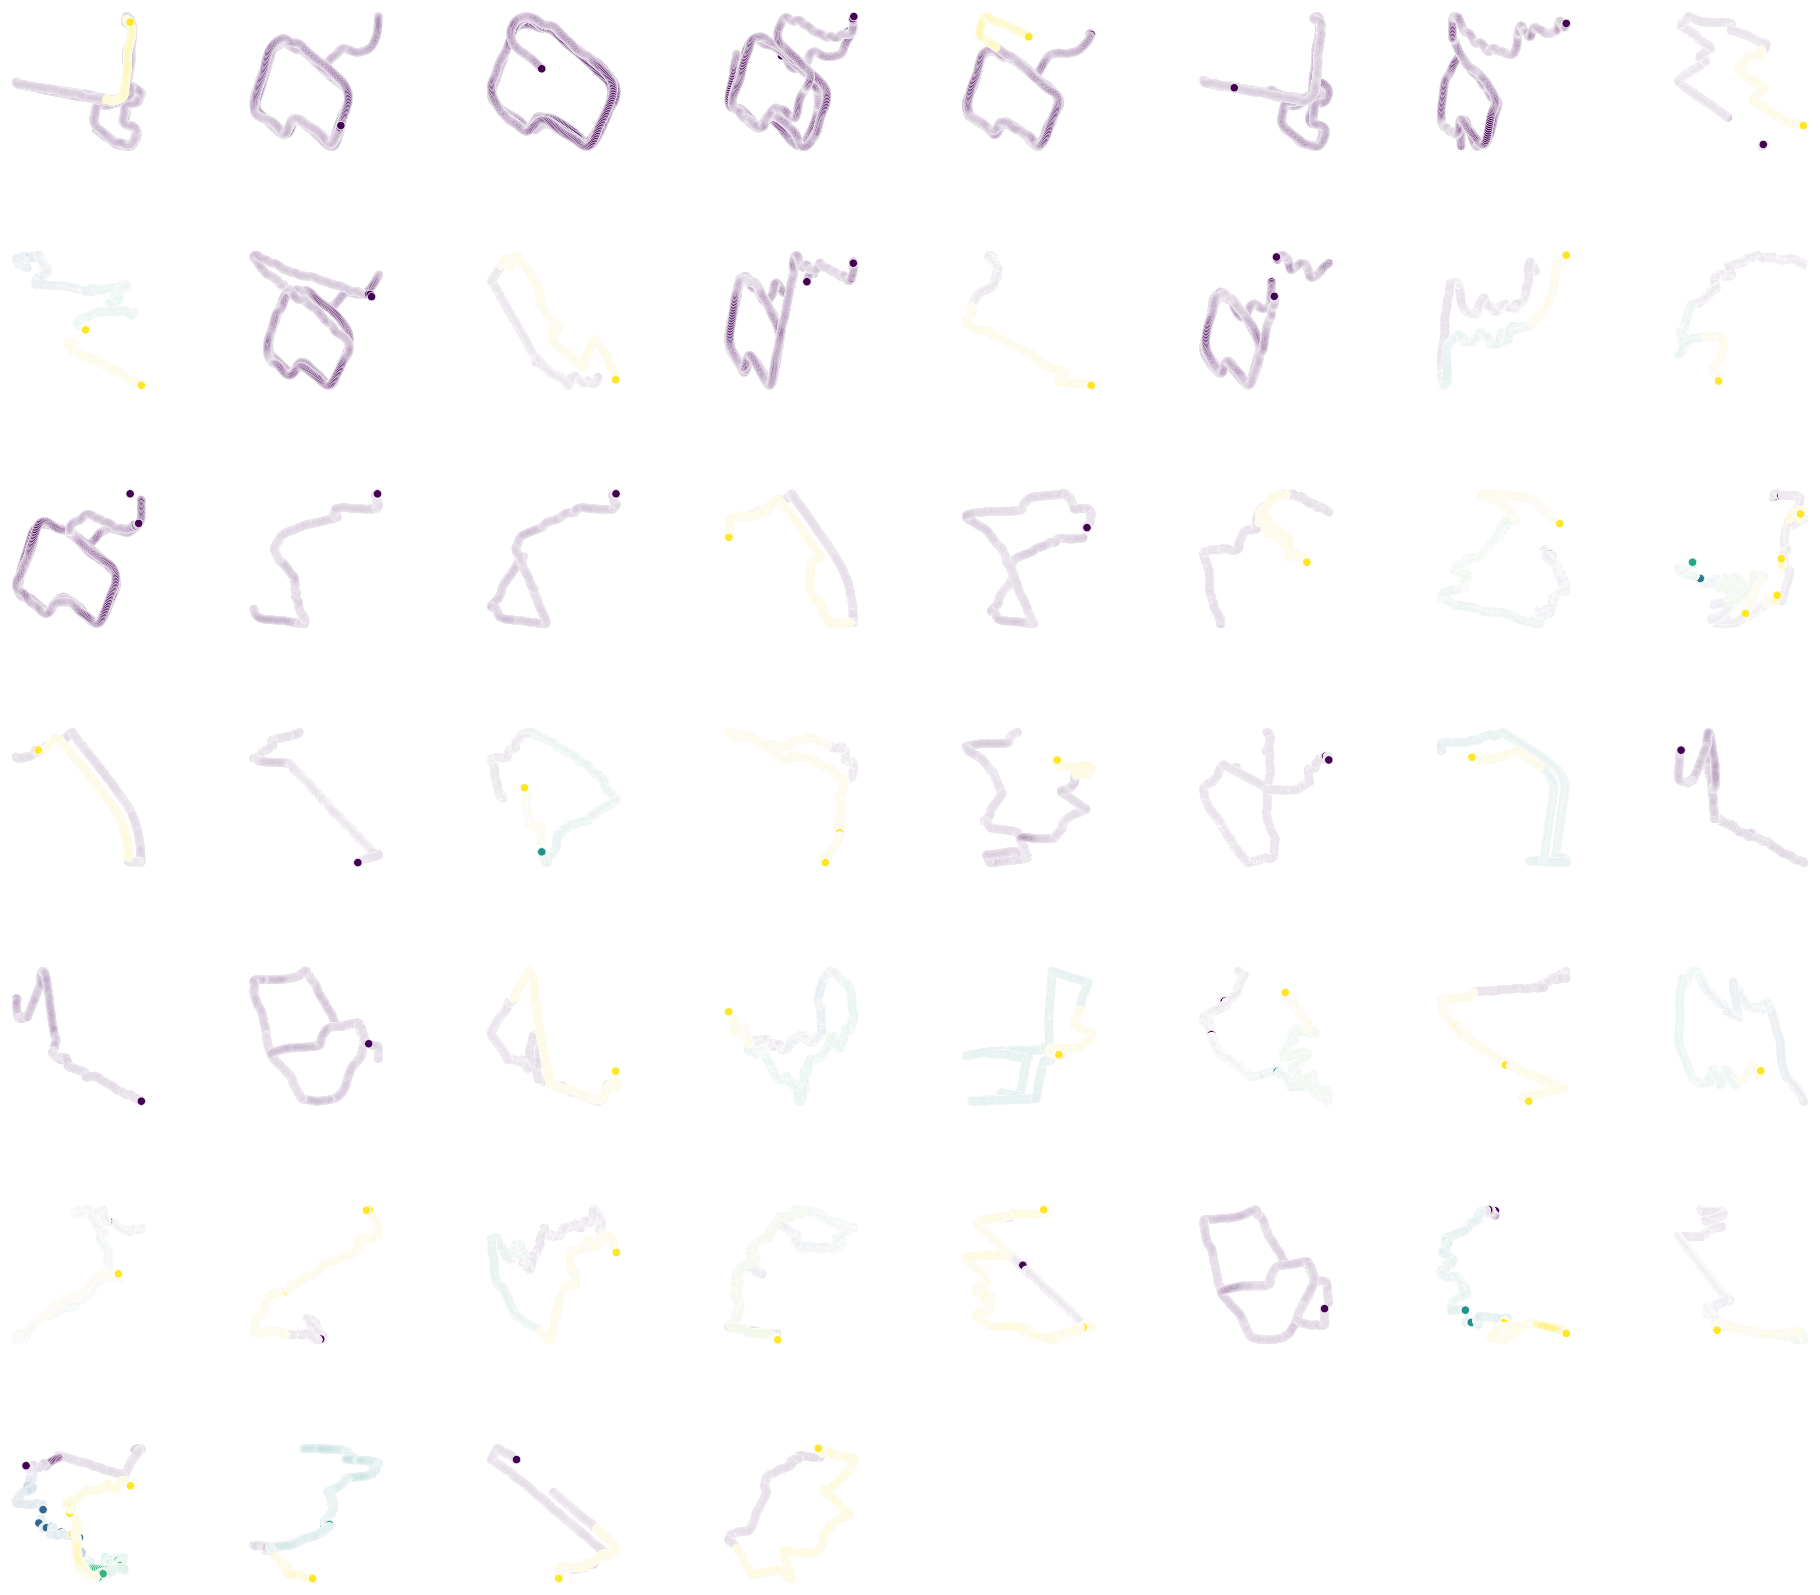

In [8]:
sns.set(style="whitegrid")

start_times = (
    df_all.groupby("name").agg({"time": "min"}).reset_index().sort_values("time")
)
ncol = math.ceil(math.sqrt(len(start_times)))

g = sns.FacetGrid(
    data=df_all,
    col="name",
    col_wrap=ncol,
    col_order=start_times["name"],
    sharex=False,
    sharey=False,
    height=2.5
)

g.map_dataframe(sns.scatterplot, x="lon", y="lat", hue="hour", palette="viridis")
g.set(xlabel=None, ylabel=None, xticks=[], yticks=[], xticklabels=[], yticklabels=[])
g.set_titles(col_template="", row_template="")
sns.despine(left=True, bottom=True)
plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95)



Optional: finally, let's save the file to a specified folder (this can be changed).

In [ ]:
output_file = os.path.join(r"local folder path here")
plt.savefig(output_file)
plt.close()

print(f"Plot successfully saved: {output_file}")

Plot successfully saved: activity_plot.png
